In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import pandas as pd 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.double)

from activephasemap.models.np import NeuralProcess
from activephasemap.models.mlp import MLP
from activephasemap.utils.simulators import UVVisExperiment
from activephasemap.utils.visuals import get_twod_grid
from activephasemap.utils.acquisition import CompositeModelUncertainity
import json 

from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colormaps 
from matplotlib.cm import ScalarMappable

pyplot_style ={"text.usetex": True,
               "text.latex.preamble": r"\usepackage{amsfonts}\usepackage[version=4]{mhchem}",
               "axes.spines.right" : False,
               "axes.spines.top" : False,
               "font.size": 22,
               "savefig.dpi": 600,
               "savefig.bbox": 'tight',
              } 

In [2]:
DATA_DIR = "./output/"
ITERATION = 1
with open('/Users/pozzolabadmin/Documents/codebase/experiments/peptide_phase_mapping/04012024/best_config.json') as f:
    best_np_config = json.load(f)
N_LATENT = best_np_config["z_dim"]

In [3]:
# Load trained MLP model for p(z|c)
train_x = torch.load(DATA_DIR+'/train_x_%d.pt'%ITERATION, map_location=device)
train_z_mean = torch.load(DATA_DIR+'/train_z_mean_%d.pt'%ITERATION, map_location=device)
train_z_std = torch.load(DATA_DIR+'/train_z_std_%d.pt'%ITERATION, map_location=device)
mlp = MLP(train_x, train_z_mean, train_z_std)
mlp_state_dict = torch.load(DATA_DIR+'/comp_model_%d.pt'%(ITERATION), map_location=device)
mlp.load_state_dict(mlp_state_dict)

# Load trained NP model for p(y|z)
NP = NeuralProcess(best_np_config["r_dim"], N_LATENT, best_np_config["h_dim"]).to(device)
NP.load_state_dict(torch.load(DATA_DIR+'/np_model_%d.pt'%(ITERATION), map_location=device))

design_space_bounds = [(0.0, 87.0), (0.0,11.0)]

In [4]:
expt = UVVisExperiment(design_space_bounds, "./data/")
expt.read_iter_data(ITERATION)
expt.generate(use_spline=True)

Loading data from iteration 0 with shapes: (24, 2) (24, 101)


In [5]:
def prettify_axis(ax):
    ax.set_xlabel('Z2 concentration (mM)')
    ax.set_ylabel('Time delay (min)') 
    ax.set_xlim(*design_space_bounds[0])
    ax.set_ylim(*design_space_bounds[1])
    ax.xaxis.set_major_locator(ticker.LinearLocator(3))
    ax.yaxis.set_major_locator(ticker.LinearLocator(5))
    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    vol_labels = [item.get_text() for item in ax.get_xticklabels()]
    z2_vol_to_conc = lambda v : (0.3*v)/(280.0-v)
    conc_labels = []
    for l in vol_labels:
        conc_labels.append("%.2f"%z2_vol_to_conc(float(l)))
    ax.set_xticklabels(conc_labels)
    
    return ax

/var/folders/84/z8kd1tl11hl96fsszww81rx40000gp/T/ipykernel_4478/1967543172.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(conc_labels)


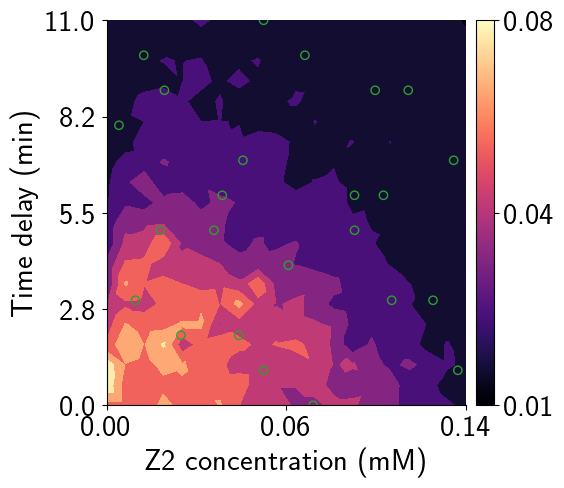

In [6]:
acquisition = CompositeModelUncertainity(expt.t, expt.bounds, NP, mlp)
C_grid = get_twod_grid(20, expt.bounds.cpu().numpy())
with torch.no_grad():
    acq_values = acquisition(torch.tensor(C_grid).reshape(len(C_grid),1,2)).squeeze().cpu().numpy()
cmap = colormaps["magma"]
norm = Normalize(vmin=min(acq_values), vmax = max(acq_values))
mappable = ScalarMappable(norm=norm, cmap=cmap)

with torch.no_grad(), plt.style.context(pyplot_style):
    fig, ax = plt.subplots(figsize=(5,5))
    ax.tricontourf(C_grid[:,0], C_grid[:,1], acq_values, cmap=cmap, norm=norm)
    x_ = expt.comps
    ax.scatter(x_[:,0], x_[:,1], facecolors='none', edgecolors='tab:green')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax)
    cbar.ax.yaxis.set_major_locator(ticker.LinearLocator(3))
    cbar.ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
    prettify_axis(ax)
    plt.savefig("./figures/acqf_%d.png"%ITERATION)   
    plt.show()